# Similar cities to Barueri in Sorocaba region
#### Rodrigo Medeiros

## Introduction

A retired couple which lives in Barueri desire to move to Sorocaba region to be close to their family, they don't know very well the region and have concerns about the city they are going to choose. They intend to move to a city similar to Barueri in terms of social development, demographic density, availability of restaurants, parks, museums and so on.

To verify the cities in Sorocaba region that are similar to Barueri in this aspects, will be used technics of web scrapping data and machine learning to identify and propose cities with best odds to satisfy the couple.

## Data Description

To find out the most similar cities to Barueri in Sorocaba region will be used the following data:

 - The Barueri geographical information will be retrieve from Barueri page on Wikipédia (https://pt.wikipedia.org/wiki/Barueri), in this page is possible to found information about the total area of the city in Km^2, total population and Human Development Index;
 
 
 - A table with geographical informtaion from the cities in Sorocaba region will be retrieve from Metropolitan Region of Sorocaba page on Wikipédia (https://pt.wikipedia.org/wiki/Regi%C3%A3o_Metropolitana_de_Sorocaba), in this table as available the same information retrieved from Barueri in its page;

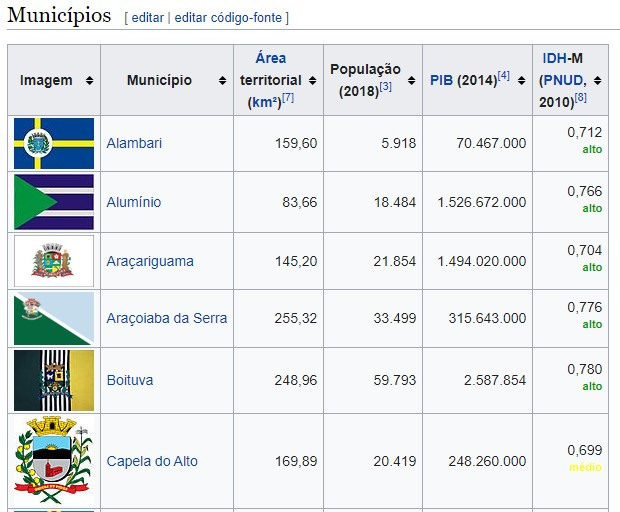

<center> Table from Metropolitan Sorocaba Region wikipédia page </center>

 - The Foursquare API will be used to retrieve the venues for each city, this API returns a json file containing all the information of the venues in a certain radius of a given location. In this project will be considered the venues in a radius of 7Km from the city coordinate, the information that will be retrieve from this file will be the category of the venues and its quantity per city;

## Metodology

### Data acquisition and cleaning

In [7]:
# importing the necessary packages
# package to manage the request
import urllib.request
import requests as rq

# packages to manage the data
import pandas as pd
import numpy as np

# packages to manage the json files
import json
from pandas.io.json import json_normalize

# packages to manage the plots
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

# package to scale the data
from sklearn.preprocessing import StandardScaler

# package to cluster the data
from sklearn.cluster import KMeans

# package to parse the webpages
from bs4 import BeautifulSoup

# package to get the coordinates
import geocoder

The first step is retrieve the Barueri information from its page on Wikipédia. Todo this we create a variable to store the url and another to store the html code of the page, to easily navigate in this code use **BeautifulSoup4** and transform this variable in a Beautiful Soup object.

In [8]:
# define a variable to store the url
url_bar = 'https://pt.wikipedia.org/wiki/Barueri'

# store the page into another variable
page_bar = urllib.request.urlopen(url_bar)

# create a BeutifulSoup object
soup_bar = BeautifulSoup(page_bar, 'lxml')

In a Beautiful Soup object is possible navigate through the html tags. To know excatly in which part of the page are the information is necessary exam the page code, it can be easily done using the development tools of your web browser, in this case the informations are in a table with attribute class 'infobox_v2'. To locate the table where the information are use the method _find_ with the tag 'table' and indicate its class, the result need to be stored in a variable.

To retrieve the text information from this variable, create two lists (one for each table's column), then iteract through the rows with a for loop and store the cells content in a variable, check if the length is as expected and then use the method _get_text_ to append the text information of the line to the correspondent list.

After having the text informtaion into the lists create a dataframe.

In [9]:
# find the table with information needed
table_bar = soup_bar.find('table', class_='infobox_v2')

# extract the table text into lists
A = []
B = []

for row in table_bar.find_all('tr'):
    cells = row.find_all('td')
    if len(cells) == 2:
        A.append(cells[0].get_text())
        B.append(cells[1].get_text())

# creating a dataframe from the lists
df_bar = pd.DataFrame(A, dtype='str', columns=['Caracteristics'])
df_bar['Values'] = B

df_bar

,Caracteristics,Values
0,Bandeira,Brasão de armas
1,Lema\n,Flor vermelha que encanta\n
2,Apelido(s)\n,"""Flor vermelha que encanta""\n"
3,Gentílico\n,barueriense[1]\n
4,Coordenadas\n,"23° 30' 38"" S 46° 54' 34"" O\n"
5,País\n,Brasil\n
6,Unidade federativa\n,São Paulo\n
7,Região intermediária[2]\n,São Paulo\n
8,Região imediata[2]\n,São Paulo\n
9,Região metropolitana\n,São Paulo\n


Analysing the dataframe is possible to identify that the relevant information for the project are on lines with index 16, 17 and 22. Pass this information to a dictionary using slice techniques to exclude undesireble characteres, and then transform it in a dataframe.

In [10]:
# creating a dataframe with useful information from Barueri
data_bar = {'City':['Barueri'], 
            'Area':[df_bar['Values'][16][:6]],
            'Population':[df_bar['Values'][17][:3] + df_bar['Values'][17][4:7]],
            'HDI':[df_bar['Values'][22][:5]]
           }

df_dbar = pd.DataFrame(data=data_bar)
df_dbar

,City,Area,Population,HDI
0,Barueri,"65,701",274182,"0,786"


In [11]:
# define a variable to store the url
url_sr = 'https://pt.wikipedia.org/wiki/Regi%C3%A3o_Metropolitana_de_Sorocaba'

# store the page into another variable
page_sr = urllib.request.urlopen(url_sr)

# create a BeutifulSoup object
soup_sr = BeautifulSoup(page_sr, 'lxml')

To retrieve the information from Sorocaba region, again generate a Beuatiful Soup object and copy from it the table which has the information desired. This time create lists and appended information on them only the columns needed in the project, also the clean the text with slice techinics directely on _get_text_ method. Create a new dataframe with information of Sorocaba region.

In [13]:
# find the table with information needed
table_sr = soup_sr.find('table', class_='wikitable sortable')


# extract the table text into lists
A = []
B = []
C = []
D = []

for row in table_sr.find_all('tr'):
    cells = row.find_all('td')
    if len(cells) == 6:
        A.append(cells[1].get_text()[:-1]) 
        B.append(cells[2].get_text()[:-1])
        C.append(cells[3].get_text()[:-1])
        if len(cells[5].get_text()) == 10: # conditional clause used to slice the data and get only the numbers
            D.append(cells[5].get_text()[:-5])
        else:
            D.append(cells[5].get_text()[:-6])

# creating a dataframe from the lists
df_sr = pd.DataFrame(A, columns=['City'])
df_sr['Area'] = B
df_sr['Population'] = C
df_sr['HDI'] = D

df_sr

,City,Area,Population,HDI
0,Alambari,"159,60",5.918,"0,712"
1,Alumínio,"83,66",18.484,"0,766"
2,Araçariguama,"145,20",21.854,"0,704"
3,Araçoiaba da Serra,"255,32",33.499,"0,776"
4,Boituva,"248,96",59.793,"0,780"
5,Capela do Alto,"169,89",20.419,"0,699"
6,Cerquilho,"127,80",48.074,"0,782"
7,Cesário Lange,"190,39",17.915,"0,706"
8,Ibiúna,"1.058,08",78.262,"0,710"
9,Iperó,"170,28",36.280,"0,719"


Create a new dataframe with information from Sorocaba region and Barueri, to avoid future problems sort the dataframe by the coloumn 'City' and reset its index. 

Now this dataframe has the inicial information from Barueri and Sorocaba region, but the data on columns 'Area', 'Population' and 'HDI' are in string format. To solve that issue first remove all points of the data and replace all the decimal commas with decimal points, then convert the columns to float or int type.

In [14]:
# Create a new dataframe including Barueri information
df_cities = df_sr.append(df_dbar)
df_cities = df_cities.sort_values(['City'], ascending=True)
df_cities.reset_index(drop=True, inplace=True)

# converting Area column to float type
df_cities['Area'] = [x.replace(".", "") for x in df_cities['Area']]
df_cities['Area'] = [x.replace(",", ".") for x in df_cities['Area']]
df_cities['Area'] = df_cities['Area'].astype('float')

# converting Area column to int type
df_cities['Population'] = [x.replace(".", "") for x in df_cities['Population']]
df_cities['Population'] = df_cities['Population'].astype('int')

# converting Area column to float type
df_cities['HDI'] = [x.replace(",", ".") for x in df_cities['HDI']]
df_cities['HDI'] = df_cities['HDI'].astype('float')

The **geocoder** package will be used to retrieve the coordinates of eache city, this information will be necessary to plot the maps and also to retrive venues information from Foursquare. To do that iteract with each row of the dataframe using a for loop, note that because of the reliability of this package is necessary put a while loop inside the for loop to guarantee that the response is not None. Store the coordinates in lists and then create two new columns on dataframe 'Latitude' and 'Longitude'. This finish the cities dataframe.

In [15]:
# creating the lists to store the coordinates
latitude=[]
longitude=[]

# the loop to interact with all rows in data frame
for city in df_cities['City']:
    
    # variable to control the while loop
    lat_long_coord = None
    
    # while loop to guarantie that the result is not none, needs because this package is unreliable
    while (lat_long_coord is None):
        #print('send request')
        g = geocoder.arcgis('{}, São Paulo, BRA'.format(city))
        lat_long_coord = g.latlng
    
    # storing the latitudes and longitudes 
    latitude.append(lat_long_coord[0])
    longitude.append(lat_long_coord[1])

In [16]:
# including the latitude and longitude information on dataframe
df_cities['Latitude'] = latitude
df_cities['Longitude'] = longitude

df_cities

,City,Area,Population,HDI,Latitude,Longitude
0,Alambari,159.600,5918,0.712,-23.55100,-47.90006
1,Alumínio,83.660,18484,0.766,-23.52186,-47.25471
2,Araçariguama,145.200,21854,0.704,-23.43502,-47.06784
3,Araçoiaba da Serra,255.320,33499,0.776,-23.50521,-47.61543
4,Barueri,65.701,274182,0.786,-23.50430,-46.84463
5,Boituva,248.960,59793,0.780,-23.28396,-47.67219
6,Capela do Alto,169.890,20419,0.699,-23.46930,-47.73352
7,Cerquilho,127.800,48074,0.782,-23.16760,-47.74733
8,Cesário Lange,190.390,17915,0.706,-23.22465,-47.95570
9,Ibiúna,1058.080,78262,0.710,-23.65717,-47.22366


The **Foursquare API** provide information about hte venues in a certain radius for a given coordinate, using this API retrieve venues' information of a radius of 7Km from the city coordinates.

In [17]:
# @hidden_cell
CLIENT_ID = 'WI1MK0RKBDWNBJ2PEA5GXNVJ0I0RB2MA3MJLVEWJVC553UCC' 
CLIENT_SECRET = 'PO2SNHR1KUCQD4GQT0HIKNWBV4CJYQEDF2IO1A4TKYDAEFUT'

Create a function to do the requests and store the data into a new dataframe. 

This function receives 4 paramenters, the first one is a series of names, the second a series of latitudes, the third a series of longitudes and the last the radius (this have a default value of 7000). The function will iteract with the input series and generate the url to request the data from the API, then this url is used with the methods _get_ and _json_ from **requests** package to store the response of the API in a variable. Once this variable receive the json file the function navigate through it and stores the data of the venue in a list, this list is used to generate a new data frame with the information of the venues retrieved from Foursquare. Check the first rows of venues dataframe.

In [18]:
# other parameters to Foursquare API
VERSION = '20200628'
LIMIT = 200

In [19]:
# Function to get the venues for each city
def getNearbyVenues(names, latitudes, longitudes, radius=7000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
              
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = rq.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
region_venues = getNearbyVenues(names=df_cities['City'],
                                latitudes=df_cities['Latitude'],
                                longitudes=df_cities['Longitude']
                               )

In [21]:
region_venues.head(10)

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alambari,-23.55100,-47.90006,Pizza Alambari,-23.550681,-47.897981,Pizza Place
1,Alambari,-23.55100,-47.90006,Pousada Alambari,-23.552388,-47.900047,Bed & Breakfast
2,Alambari,-23.55100,-47.90006,Padaria Mariano,-23.563269,-47.888840,Bakery
3,Alambari,-23.55100,-47.90006,Gargolandia,-23.576297,-47.878087,Music Venue
4,Alumínio,-23.52186,-47.25471,Villas,-23.533111,-47.256275,Buffet
5,Alumínio,-23.52186,-47.25471,Padaria Pedágio,-23.517960,-47.257102,Bakery
6,Alumínio,-23.52186,-47.25471,Padaria Estrela,-23.536890,-47.190466,Bakery
7,Alumínio,-23.52186,-47.25471,Refeitório CBA - Sodexo,-23.534946,-47.261412,Restaurant
8,Alumínio,-23.52186,-47.25471,Cachorrão do Abner Lanchonete e Pastelaria,-23.536452,-47.190926,Hot Dog Joint
9,Alumínio,-23.52186,-47.25471,Fazenda Terra da Mata,-23.473520,-47.297546,Theme Park Ride / Attraction


### Exploratory Analisys

Start analisys exploring the dataset is a good way to discover some interesting points and has the first insights. 

Using **folium** package is possible to render a map and see how the cities spread.

In [23]:
# generating the map with the cities
map_region = folium.Map(location=[-23.472925, -47.190285], zoom_start=9.47)

for lat, lon, poi in zip(df_cities['Latitude'], df_cities['Longitude'], df_cities['City']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_region)

map_region

In the map is possible verify that the Sorocaba region is very large and the cities are no so close from each other, as this region is in countryside of São Paulo its can indicate a strong agricultural activity. 

Also the map shows that Barueri is close to São Paulo city which indicate a more strong comercial and industrial activity. Considering this is probable that will be difficulty to find a similar city to Barueri in Sorocaba region.

Grouping the venues dataframe by city is possible check how many venues are registered on Foursquare in each city.

In [27]:
# checking how many venues each city has
counted = region_venues.groupby('City').count()
counted

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Alambari,4,4,4,4,4,4
Alumínio,6,6,6,6,6,6
Araçariguama,24,24,24,24,24,24
Araçoiaba da Serra,16,16,16,16,16,16
Barueri,100,100,100,100,100,100
Boituva,53,53,53,53,53,53
Capela do Alto,4,4,4,4,4,4
Cerquilho,27,27,27,27,27,27
Cesário Lange,9,9,9,9,9,9


After this count is possible see that only some cities in this region has a good amount of venues, reinforcing the idea that these city are in the most part small cities where the commercial sector is not desenvolve.

Is possible to assume that the cities with closest number of venues has more odds to be similar with Barueri.

Other point that is possible to explore is check how many categories of venues are.

In [32]:
print('There are {} uniques categories.'.format(len(region_venues['Venue Category'].unique())))

There are 178 uniques categories.


### Clustering

To start the clustering process first the venues category must be transform in a numeric variable, this was done using the pandas method **get_dummies** from pandas to create a new dataframe, this dataframe has a column to each venue category and indicates 1 in the column of the venue category and 0 on others. Also the was added the city column to this new dataframe.

In [18]:
# encoding the categories in a new dataframe
# one hot encoding
onehot_sr = pd.get_dummies(region_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot_sr['City'] = region_venues['City'] 

# define a list of column names
cols = onehot_sr.columns.tolist()
cols

# move the column name to the beggining
cols.insert(0, cols.pop(cols.index('City')))
cols

#then use .reindex() function to reorder
onehot_sr = onehot_sr.reindex(columns= cols)

#check result
onehot_sr.head()

,City,Acai House,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Toll Plaza,Track,Trail,Video Store,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Zoo
0,Alambari,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alambari,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alambari,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alambari,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Alumínio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


After creating this new dataframe was possible to group by City and score each city with the mean values of each category. 

In [41]:
# grouping by city
region_grouped = onehot_sr.groupby('City').mean().reset_index()
region_grouped

,City,Acai House,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Toll Plaza,Track,Trail,Video Store,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Zoo
0,Alambari,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,...,0.0000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00
1,Alumínio,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,...,0.0000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00
2,Araçariguama,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,...,0.0000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00
3,Araçoiaba da Serra,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,...,0.0000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00
4,Barueri,0.010000,0.000000,0.000000,0.00,0.00,0.000000,0.01,0.010000,0.000000,...,0.0000,0.02,0.000000,0.000000,0.01,0.01,0.010000,0.000000,0.01,0.00
5,Boituva,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.037736,...,0.0000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00
6,Capela do Alto,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,...,0.0000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00
7,Cerquilho,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,...,0.0000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00
8,Cesário Lange,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,...,0.0000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00
9,Ibiúna,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,...,0.0000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00


In [42]:
# function to sorte the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Once the categories now are numerical values was defined a function to sort them in descending order, this put the most comuns venues in each city colser to city name and provide a glimpse of cities similarity.

Below is possible to see the top 10 most frequently venues categories per city.

In [47]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = region_grouped['City']

for ind in np.arange(region_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(region_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alambari,Bakery,Pizza Place,Music Venue,Bed & Breakfast,Zoo,Flea Market,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm
1,Alumínio,Bakery,Hot Dog Joint,Buffet,Restaurant,Theme Park Ride / Attraction,Zoo,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm
2,Araçariguama,Convenience Store,Campground,Grocery Store,BBQ Joint,Bed & Breakfast,Plaza,Department Store,Museum,Scenic Lookout,Buffet
3,Araçoiaba da Serra,Farm,Churrascaria,Plaza,Grocery Store,Snack Place,Soccer Field,Bed & Breakfast,Market,Deli / Bodega,Brazilian Restaurant
4,Barueri,Burger Joint,Dessert Shop,Café,Pizza Place,Bakery,Park,Restaurant,Bookstore,Coffee Shop,Steakhouse
5,Boituva,Bakery,Pizza Place,Café,Hotel,Gym / Fitness Center,Coffee Shop,Restaurant,Fast Food Restaurant,Flea Market,Skydiving Drop Zone
6,Capela do Alto,Gym / Fitness Center,Grocery Store,Supermarket,General Travel,Zoo,Dessert Shop,Fast Food Restaurant,Farmers Market,Farm,Electronics Store
7,Cerquilho,Burger Joint,Brazilian Restaurant,Supermarket,Ice Cream Shop,Bar,Bakery,Middle Eastern Restaurant,Mexican Restaurant,Soccer Field,Restaurant
8,Cesário Lange,Bakery,Market,Hotel,Hotel Bar,Convenience Store,Resort,Middle Eastern Restaurant,BBQ Joint,Breakfast Spot,Flea Market
9,Ibiúna,Bakery,Japanese Restaurant,Hotel,Grocery Store,Brazilian Restaurant,BBQ Joint,Supermarket,Soup Place,South American Restaurant,Restaurant


To cluster method consider also the geographical information about the cities was added the columns _Area_, _Population_ and _HDI_. 

As the magnitude of these new columns differ a lot of the columns with the means of venues categories was used the **StandardScaler** method from SKlearn package to scale the columns and give them the same weigth in the clustering process.

In [22]:
#inserting the other information to DF
region_grouped['Area'] = df_cities['Area']
region_grouped['Population'] = df_cities['Population']
region_grouped['HDI'] = df_cities['HDI']

region_grouped.head()

,City,Acai House,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Video Store,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Zoo,Area,Population,HDI
0,Alambari,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.00,0.00,0.00,0.0,0.00,0.0,159.600,5918,0.712
1,Alumínio,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.00,0.00,0.00,0.0,0.00,0.0,83.660,18484,0.766
2,Araçariguama,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.00,0.00,0.00,0.0,0.00,0.0,145.200,21854,0.704
3,Araçoiaba da Serra,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.00,0.00,0.00,0.0,0.00,0.0,255.320,33499,0.776
4,Barueri,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.0,...,0.0,0.01,0.01,0.01,0.0,0.01,0.0,65.701,274182,0.786


In [23]:
clus_dataSet = StandardScaler().fit_transform(region_grouped.drop('City', axis=1))
clus_dataSet

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-0.3881064 , -0.19245009, -0.19245009, ..., -0.68441435,
        -0.62232113, -0.90363061],
       [-0.3881064 , -0.19245009, -0.19245009, ..., -0.88630603,
        -0.52406882,  0.68878137],
       [-0.3881064 , -0.19245009, -0.19245009, ..., -0.72269773,
        -0.49771912, -1.1395435 ],
       ...,
       [ 2.66441587, -0.19245009,  5.19615242, ...,  0.28367675,
         0.27384221,  0.27593382],
       [-0.3881064 , -0.19245009, -0.19245009, ..., -0.03362339,
        -0.34315509,  1.0426507 ],
       [-0.3881064 , -0.19245009, -0.19245009, ..., -0.62084798,
         0.28008169,  0.71827048]])

The method choose for the clustering process was the **K-means** which try to reduce the mean distance between the center of each cluster to its components.

The number of clusters was empiric defined as 5, which represent a good result without making the clusters too generic.

In [48]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clus_dataSet)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int32)

Once the clusters is defined is possible to put all the relevant information in one dataframe. This dataframe contains the city geographical information, the cluster defined and also the top 10 most communs venues types.

In [49]:
# add clustering labels
cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

region_merged = df_cities

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
region_merged = region_merged.join(cities_venues_sorted.set_index('City'), on='City')
region_merged['Cluster Labels'].astype('int32')

region_merged

,City,Area,Population,HDI,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alambari,159.600,5918,0.712,-23.55100,-47.90006,1,Bakery,Pizza Place,Music Venue,Bed & Breakfast,Zoo,Flea Market,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm
1,Alumínio,83.660,18484,0.766,-23.52186,-47.25471,1,Bakery,Hot Dog Joint,Buffet,Restaurant,Theme Park Ride / Attraction,Zoo,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm
2,Araçariguama,145.200,21854,0.704,-23.43502,-47.06784,1,Convenience Store,Campground,Grocery Store,BBQ Joint,Bed & Breakfast,Plaza,Department Store,Museum,Scenic Lookout,Buffet
3,Araçoiaba da Serra,255.320,33499,0.776,-23.50521,-47.61543,1,Farm,Churrascaria,Plaza,Grocery Store,Snack Place,Soccer Field,Bed & Breakfast,Market,Deli / Bodega,Brazilian Restaurant
4,Barueri,65.701,274182,0.786,-23.50430,-46.84463,0,Burger Joint,Dessert Shop,Café,Pizza Place,Bakery,Park,Restaurant,Bookstore,Coffee Shop,Steakhouse
5,Boituva,248.960,59793,0.780,-23.28396,-47.67219,1,Bakery,Pizza Place,Café,Hotel,Gym / Fitness Center,Coffee Shop,Restaurant,Fast Food Restaurant,Flea Market,Skydiving Drop Zone
6,Capela do Alto,169.890,20419,0.699,-23.46930,-47.73352,1,Gym / Fitness Center,Grocery Store,Supermarket,General Travel,Zoo,Dessert Shop,Fast Food Restaurant,Farmers Market,Farm,Electronics Store
7,Cerquilho,127.800,48074,0.782,-23.16760,-47.74733,1,Burger Joint,Brazilian Restaurant,Supermarket,Ice Cream Shop,Bar,Bakery,Middle Eastern Restaurant,Mexican Restaurant,Soccer Field,Restaurant
8,Cesário Lange,190.390,17915,0.706,-23.22465,-47.95570,1,Bakery,Market,Hotel,Hotel Bar,Convenience Store,Resort,Middle Eastern Restaurant,BBQ Joint,Breakfast Spot,Flea Market
9,Ibiúna,1058.080,78262,0.710,-23.65717,-47.22366,1,Bakery,Japanese Restaurant,Hotel,Grocery Store,Brazilian Restaurant,BBQ Joint,Supermarket,Soup Place,South American Restaurant,Restaurant


## Results & Discussion

Plotting a map giving a differnt color for each cluster is the best way to figure out the cities distribution in the clusters.

In [55]:
# create map
map_region_clus = folium.Map(location=[-23.472925, -47.190285], zoom_start=9.4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(region_merged['Latitude'], region_merged['Longitude'], region_merged['City'], region_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_region_clus)
       
map_region_clus

Is possible to identify that only Barueri and Itu are in the cluster 0. Comparing the top 10 most comum venues in this two city was found that they share 4 venues types in top 10, also other 2 types (Brazilian Restaurant and Japanese Restaurant) can be included in the Restaurant type of venue putting Itu more close to Barueri in terms of venues.  

In [52]:
region_merged.loc[region_merged['Cluster Labels'] == 0, region_merged.columns[[0] + list(range(7, region_merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Barueri,Burger Joint,Dessert Shop,Café,Pizza Place,Bakery,Park,Restaurant,Bookstore,Coffee Shop,Steakhouse
12,Itu,Bakery,Café,Brazilian Restaurant,Gym / Fitness Center,Burger Joint,Japanese Restaurant,Gym,Bar,Health & Beauty Service,Pizza Place


Checking the Geographical information about the cities is possible to see that the HDI of both are similar and although the population is close the area of Itu is bigger which suggest less problems like traffic jam.

In [ ]:
region_merged.loc[region_merged['Cluster Labels'] == 0, region_merged.columns[[0:3]]]

As expected the most part of the cities in  Sorocaba region fits one cluster, as the region is in countryside the most part of the cities has more rural activities then comercial and industrial. It is also evidenty by the clustering of Sorocaba and Votorantim together in one cluster apart of the other cities, these two cities are phisicaly close and has a big industrial activity.

### Conclusion

The analisys present that the couple should chose Itu to move, Itu is the closest city to Barueri in region in terms of venues available and development. Which indicates that they can be closer to their family in Sorocaba and move to a city very similar with the city they are used to.

A future analisys of these similarity could be improved with criminal data from the cities and other sources to identify better the venues available in each city.
